In [16]:
%reset -f

In [17]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

from collections import Counter

## Generate Data

In [18]:
n = 1000
passScore = 1300

theScores = np.random.randint(200, 801, [n,2])

theTotals = np.sum(theScores, axis=1)

df = pd.DataFrame(theScores, columns=['Quantitative', 'Verbal'])
df['Total'] = theTotals
df['Passed'] = np.where(theTotals>=passScore, 1, 0)

df

,Quantitative,Verbal,Total,Passed
0,732,272,1004,0
1,215,312,527,0
2,574,799,1373,1
3,255,511,766,0
4,756,594,1350,1
...,...,...,...,...
995,591,629,1220,0
996,769,542,1311,1
997,572,224,796,0
998,599,513,1112,0


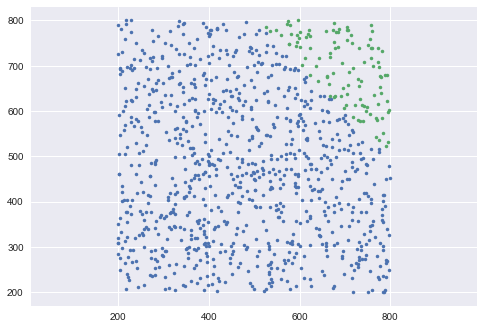

In [19]:
for ps in [0,1]:
    idx = [True if i==ps else False for i in df['Passed']]
    tdf = df[idx]
    plt.plot(tdf['Quantitative'], tdf['Verbal'], '.')

plt.axis('equal')
plt.show()

## Model and Prediction

In [20]:
data = df.drop(['Passed', 'Total'], axis=1)
target = df['Passed']

x,xt,y,yt = train_test_split(data, target)

In [21]:
# theModel = LogisticRegression()
# theModel = RandomForestClassifier(n_estimators=10, max_depth=2, class_weight='balanced')
theModel = ExtraTreesClassifier(n_estimators=10, max_depth=2, class_weight='balanced')

theModel.fit(x, y)

yp = theModel.predict(xt)

acc = round(100*accuracy_score(y_true=yt, y_pred=yp), 2)
print('Accuracy:', acc, '%')

Accuracy: 89.2 %


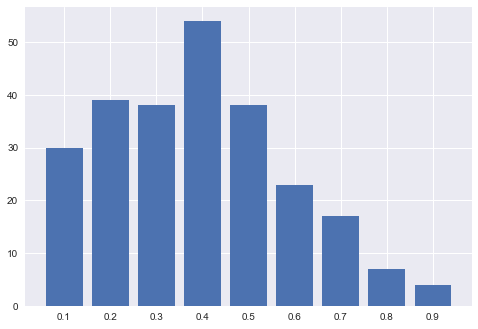

In [22]:
yProb = theModel.predict_proba(xt)[:,1]

hx = np.digitize(x=yProb, bins=np.linspace(0,1,11), right=True)
hx = sorted(Counter(hx).most_common())

px = [str(i[0]/10) for i in hx]
py = [i[1] for i in hx]
plt.bar(px, py)
plt.show()

In [23]:
pdf = pd.DataFrame(xt.values, columns=['Quantitative', 'Verbal'])
pdf['Passed'] = yt.values

pdf['Pred'] = yp
pdf['Prob'] = yProb
pdf['ProbBucket'] = np.digitize(x=yProb, bins=np.linspace(0,1,11), right=True)

pdf

,Quantitative,Verbal,Passed,Pred,Prob,ProbBucket
0,673,210,0,0,0.178677,2
1,396,281,0,0,0.150074,2
2,462,341,0,0,0.179426,2
3,469,398,0,0,0.179426,2
4,472,412,0,0,0.179426,2
...,...,...,...,...,...,...
245,492,668,0,0,0.444764,5
246,591,629,0,1,0.500640,6
247,437,351,0,0,0.179426,2
248,203,695,0,0,0.380881,4


## Calibration: Diagnosis

In [24]:
thePredProps = []

for pb in sorted(set(pdf['ProbBucket'])):
    idx = [True if i==pb else False for i in pdf['ProbBucket']]
    dist = Counter(pdf[idx]['Passed'])
    prop = dist[1]/sum(dist.values()) # actual probability of positive class in each bucket
    mnp = pdf[idx]['Prob'].mean() # mean of predicted probabilities in each bucket
    thePredProps.append( (mnp, prop) )

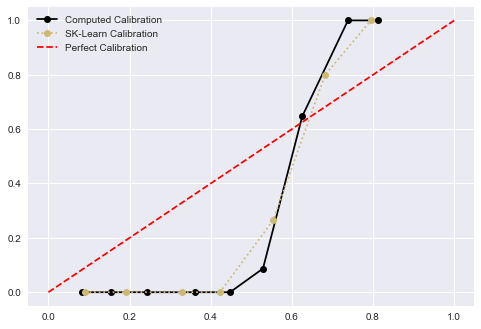

In [25]:
z = np.array(thePredProps)
perf = np.linspace(0,1,11)

nBin = len(set(pdf['ProbBucket'])) - 1
yCalib, xCalib = calibration_curve(yt, yProb, n_bins=nBin, strategy='uniform')

plt.plot(z[:,0], z[:,1], 'k-o')
plt.plot(xCalib, yCalib, 'C4:o')
plt.plot(perf, perf, 'r--')
plt.legend(['Computed Calibration', 'SK-Learn Calibration', 'Perfect Calibration'])
plt.show()

## Calibration: Remedy

In [26]:
# calibModel = CalibratedClassifierCV(theModel, cv='prefit')
calibModel = CalibratedClassifierCV(theModel, cv=3)

calibModel.fit(x, y)

ypc = calibModel.predict(xt)

acc = round(100*accuracy_score(y_true=yt, y_pred=ypc), 2)
print('Accuracy:', acc, '%')

Accuracy: 98.0 %


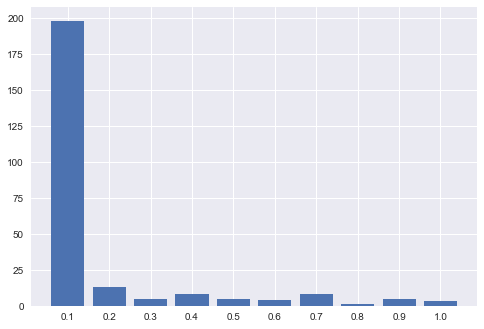

In [27]:
yCalProb = calibModel.predict_proba(xt)[:,1]

hx = np.digitize(x=yCalProb, bins=np.linspace(0,1,11), right=True)
hx = sorted(Counter(hx).most_common())

px = [str(i[0]/10) for i in hx]
py = [i[1] for i in hx]

plt.bar(px, py)
plt.show()

In [28]:
pdf['ProbCalib'] = yCalProb
pdf['ProbCalibBucket'] = np.digitize(x=yCalProb, bins=np.linspace(0,1,11), right=True)

pdf

,Quantitative,Verbal,Passed,Pred,Prob,ProbBucket,ProbCalib,ProbCalibBucket
0,673,210,0,0,0.178677,2,0.000965,1
1,396,281,0,0,0.150074,2,0.000049,1
2,462,341,0,0,0.179426,2,0.000400,1
3,469,398,0,0,0.179426,2,0.000948,1
4,472,412,0,0,0.179426,2,0.000948,1
...,...,...,...,...,...,...,...,...
245,492,668,0,0,0.444764,5,0.120185,2
246,591,629,0,1,0.500640,6,0.166962,2
247,437,351,0,0,0.179426,2,0.000143,1
248,203,695,0,0,0.380881,4,0.000918,1


In [29]:
theCalibPredProps = []

for pb in sorted(set(pdf['ProbCalibBucket'])):
    idx = [True if i==pb else False for i in pdf['ProbCalibBucket']]
    dist = Counter(pdf[idx]['Passed'])
    prop = dist[1]/sum(dist.values()) # actual probability of positive class in each bucket
    mnp = pdf[idx]['ProbCalib'].mean() # mean of predicted probabilities in each bucket
    theCalibPredProps.append( (mnp, prop) )

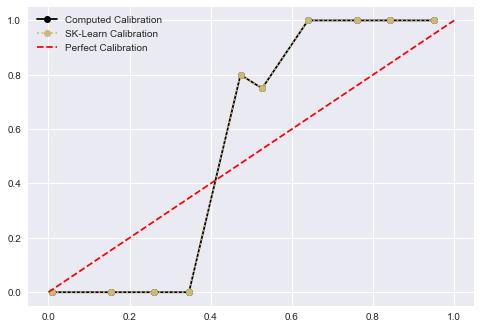

In [30]:
z = np.array(theCalibPredProps)
perf = np.linspace(0,1,11)

nBin = len(set(pdf['ProbCalibBucket']))
yCalib, xCalib = calibration_curve(yt, yCalProb, n_bins=nBin, strategy='uniform')

plt.plot(z[:,0], z[:,1], 'k-o')
plt.plot(xCalib, yCalib, 'C4:o')
plt.plot(perf, perf, 'r--')
plt.legend(['Computed Calibration', 'SK-Learn Calibration', 'Perfect Calibration'])
plt.show()